# SynapseML - Synthetic DiD on StackOverflow data

https://microsoft.github.io/SynapseML/docs/Explore%20Algorithms/Causal%20Inference/Quickstart%20-%20Synthetic%20difference%20in%20differences/

In [1]:
# Imports
import pyspark

spark = (
    pyspark.sql.SparkSession.builder.appName("MyApp")
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.10")
    .getOrCreate()
)
import synapse.ml

your 131072x1 screen size is bogus. expect trouble
25/03/06 01:44:56 WARN Utils: Your hostname, Monovo resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/06 01:44:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/m9o8/documents/bse/trimester%202/textmining/bse_tm_final/.venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/m9o8/.ivy2/cache
The jars for the packages stored in: /home/m9o8/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0daaf5be-dc6f-4fa1-abcc-ce5df560dbf5;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;1.0.10 in central
	found com.microsoft.azure#synapseml-core_2.12;1.0.10 in central
	found org.apache.spark#spark-avro_2.12;3.4.1 in central
	found org.tukaani#xz;1.9 in central
	found commons-lang#commons-lang;2.6 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in ce

## Imports

In [2]:
# Other imports
from pyspark.sql.types import *
from synapse.ml.causal import (
    DiffInDiffEstimator,
    SyntheticControlEstimator,
    SyntheticDiffInDiffEstimator,
)
from matplotlib import pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

spark.sparkContext.setLogLevel("ERROR")
style.use("ggplot")

In [3]:
df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .parquet("data/synapseml.parquet")
    .select(
        "yearweek",
        "year",
        "week",
        "forum",
        "question_count",
        "week_start",
        "avg_score",
        "avg_views",
        "avg_comments",
        "log_question_count",
        "indexed_count",
        "treatment",
        "outcome",
    )
)
display(df)

DataFrame[yearweek: int, year: int, week: tinyint, forum: string, question_count: bigint, week_start: date, avg_score: string, avg_views: string, avg_comments: string, log_question_count: double, indexed_count: double, treatment: boolean, outcome: int]

## Simple DiD

In [4]:
estimator1 = DiffInDiffEstimator(
    treatmentCol="outcome",
    postTreatmentCol="treatment",
    outcomeCol="log_question_count",
)

model1 = estimator1.fit(df)

print("[Diff in Diff] treatment effect: {}".format(model1.treatmentEffect))
print("[Diff in Diff] standard error: {}".format(model1.standardError))
print(
    "[Diff in Diff] t-statistic: {}".format(
        model1.treatmentEffect / model1.standardError
    )
)

[Diff in Diff] treatment effect: -0.24243384479669233
[Diff in Diff] standard error: 0.1138009507079974
[Diff in Diff] t-statistic: -2.1303323328005837


/home/m9o8/documents/bse/trimester 2/textmining/bse_tm_final/.venv/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Sythetic Control Estimator
Not usuable here, this will just give us the averaged distance between both control and treatment groups

In [5]:
estimator2 = SyntheticControlEstimator(
    timeCol="yearweek",
    unitCol="forum",
    treatmentCol="outcome",
    postTreatmentCol="treatment",
    outcomeCol="log_question_count",
    maxIter=5000,
    numIterNoChange=50,
    tol=1e-4,
    stepSize=1.0,
)

model2 = estimator2.fit(df)

print("[Synthetic Control] treatment effect: {}".format(model2.treatmentEffect))
print("[Synthetic Control] standard error: {}".format(model2.standardError))
print(
    "[Diff in Diff] t-statistic: {}".format(
        model2.treatmentEffect / model2.standardError
    )
)

[Synthetic Control] treatment effect: 2.393974548620338
[Synthetic Control] standard error: 0.12697060326334966
[Diff in Diff] t-statistic: 18.854557567589065


/home/m9o8/documents/bse/trimester 2/textmining/bse_tm_final/.venv/lib/python3.12/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


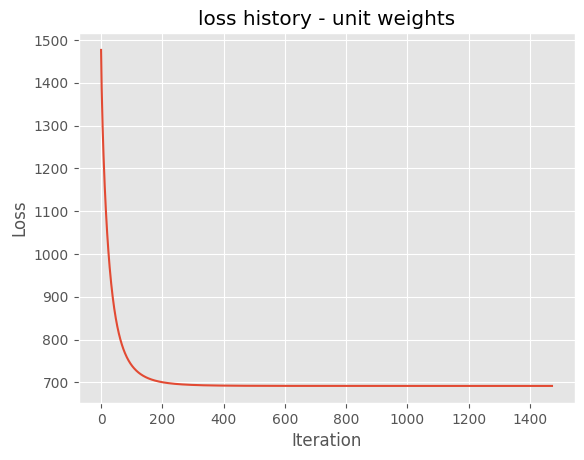

Mimimal loss: 691.7089248150052


In [6]:
lossHistory = pd.Series(np.array(model2.lossHistoryUnitWeights))

plt.plot(lossHistory)
plt.title("loss history - unit weights")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

print("Mimimal loss: {}".format(lossHistory.min()))

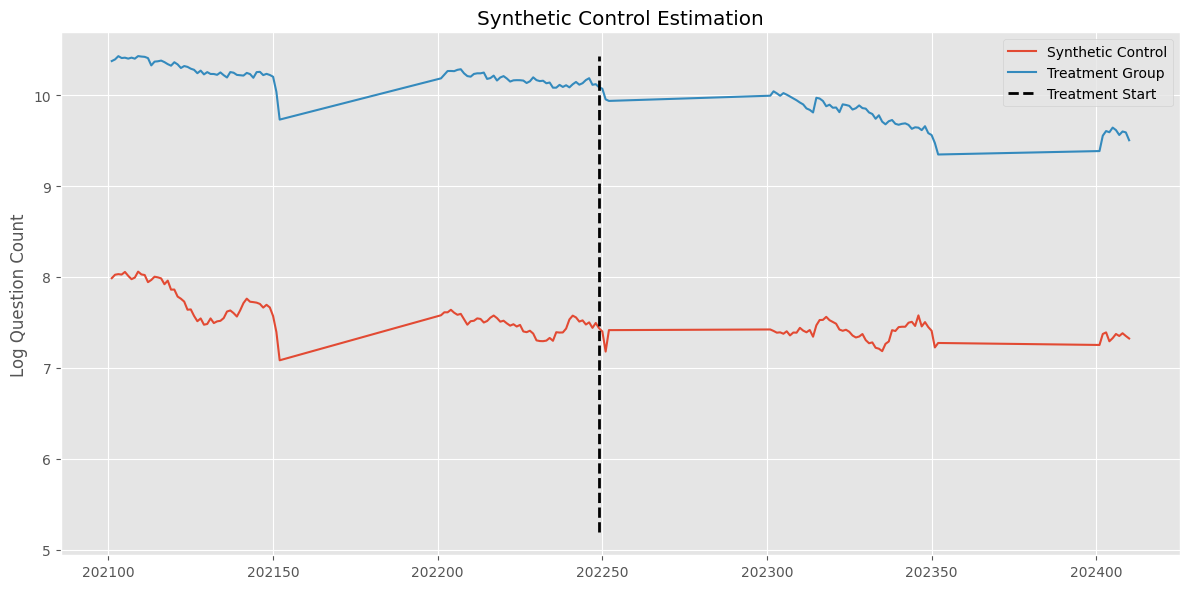

In [7]:
# Get weights from the model
sc_weights = model2.unitWeights.toPandas().set_index("forum")

# Load the full dataframe (don't filter yet)
pdf = df.toPandas()

# Create separate dataframes for control and treatment groups
control_df = pdf[pdf["outcome"] == 0]
treatment_df = pdf[pdf["outcome"] == 1]

# Create synthetic control by using control data and the weights
sc = control_df.pivot(
    index="yearweek", columns="forum", values="log_question_count"
).dot(sc_weights)

# Create a plot
plt.figure(figsize=(12, 6))

# Plot synthetic control
plt.plot(sc, label="Synthetic Control")

# Plot the actual treatment data
treatment_data = treatment_df.groupby("yearweek")["log_question_count"].mean()
plt.plot(
    treatment_data.index, treatment_data.values, label="Treatment Group", color="C1"
)

# Get treatment start date (first period where treatment == 1)
treatment_start = pdf[pdf["treatment"] == 1]["yearweek"].min()

plt.title("Synthetic Control Estimation")
plt.ylabel("Log Question Count")
plt.vlines(
    x=treatment_start,  # Use the actual treatment start date
    ymin=pdf["log_question_count"].min(),
    ymax=pdf["log_question_count"].max(),
    linestyles="--",
    linewidth=2,
    label="Treatment Start",
    color="black",
)
plt.legend()
plt.tight_layout()
plt.show()

## Synthetic DiD
This will give us the most reliable treatment effect estimate, since it weighs both time and groups

In [8]:
estimator3 = SyntheticDiffInDiffEstimator(
    timeCol="yearweek",
    unitCol="forum",
    treatmentCol="outcome",
    postTreatmentCol="treatment",
    outcomeCol="log_question_count",
    maxIter=5000,
    numIterNoChange=50,
    tol=1e-4,
    stepSize=1.0,
)

model3 = estimator3.fit(df)

print("[Synthetic Diff in Diff] treatment effect: {}".format(model3.treatmentEffect))
print("[Synthetic Diff in Diff] standard error: {}".format(model3.standardError))
print(
    "[Synthetic Diff in Diff] t-statistic: {}".format(
        model3.treatmentEffect / model3.standardError
    )
)

[Synthetic Diff in Diff] treatment effect: -0.30355183012168363
[Synthetic Diff in Diff] standard error: 0.06748042691783716
[Synthetic Diff in Diff] t-statistic: -4.498368549020627


/home/m9o8/documents/bse/trimester 2/textmining/bse_tm_final/.venv/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/home/m9o8/documents/bse/trimester 2/textmining/bse_tm_final/.venv/lib/python3.12/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


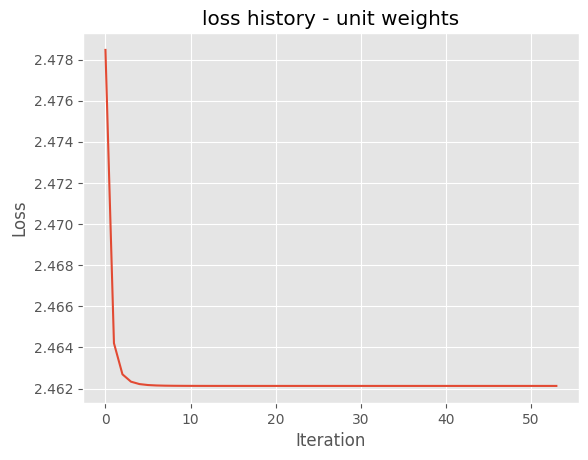

Mimimal loss: 2.4621287250489865


In [9]:
lossHistory = pd.Series(np.array(model3.lossHistoryUnitWeights))

plt.plot(lossHistory)
plt.title("loss history - unit weights")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

print("Mimimal loss: {}".format(lossHistory.min()))

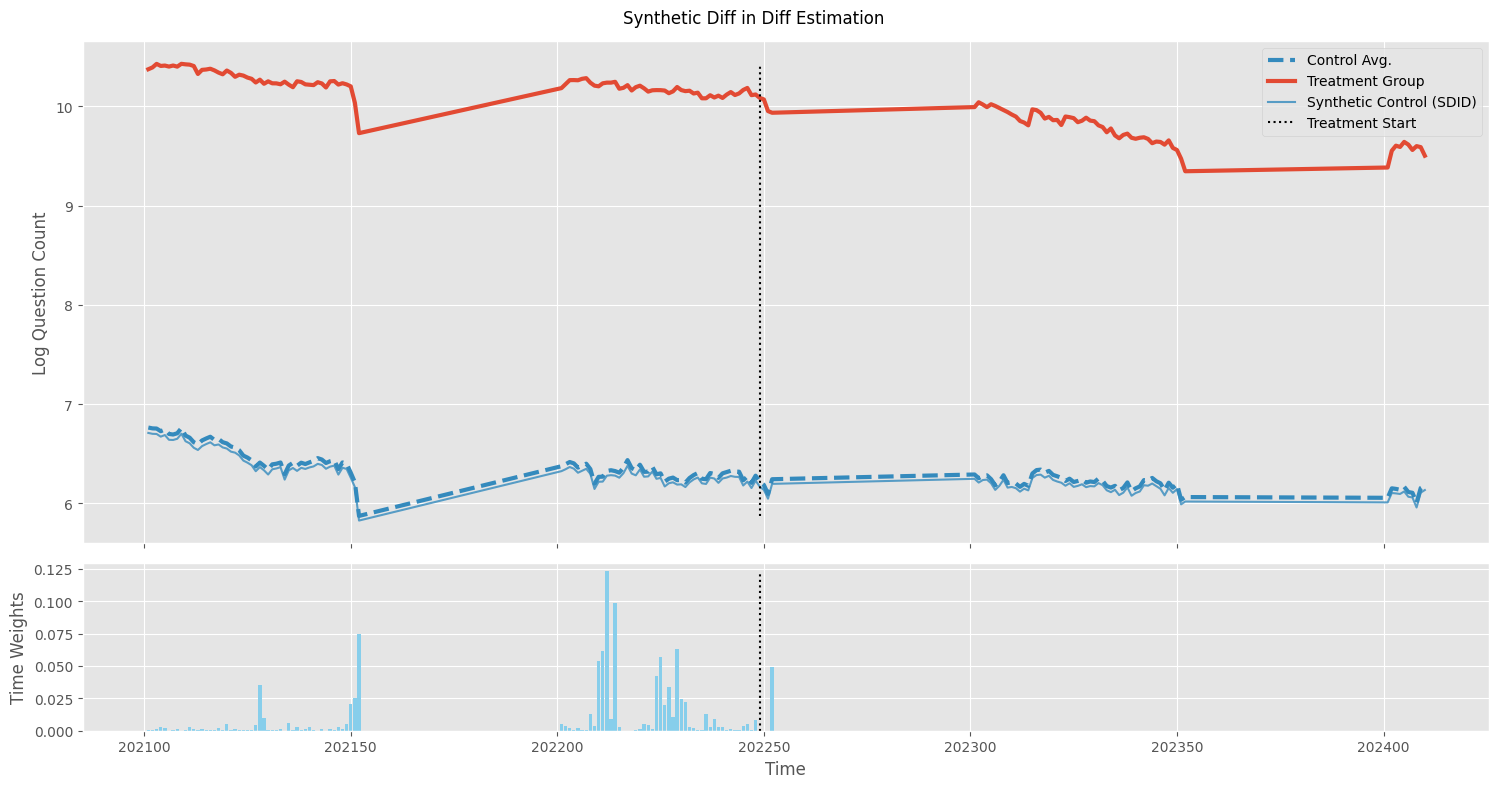

In [10]:
# Get unit and time weights from the model
unit_weights = model3.unitWeights.toPandas().set_index("forum")
unit_intercept = model3.unitIntercept

time_weights = model3.timeWeights.toPandas().set_index("yearweek")
time_intercept = model3.timeIntercept

# Get the full dataframe
pdf = df.toPandas()

# Create separate dataframes for control and treatment groups
control_df = pdf[pdf["outcome"] == 0]
treatment_df = pdf[pdf["outcome"] == 1]

# Check for duplicates and aggregate if needed
control_agg = (
    control_df.groupby(["yearweek", "forum"])["log_question_count"].mean().reset_index()
)
treatment_agg = (
    treatment_df.groupby(["yearweek", "forum"])["log_question_count"]
    .mean()
    .reset_index()
)

# Create pivot tables
pivot_df_control = control_agg.pivot(
    index="yearweek", columns="forum", values="log_question_count"
)

pivot_df_treat = treatment_agg.pivot(
    index="yearweek", columns="forum", values="log_question_count"
)

# Calculate synthetic control
sc_did = pivot_df_control.values @ unit_weights.values

# Calculate mean of treatment group
treated_mean = pivot_df_treat.mean(axis=1)

# Create plot
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(15, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)
fig.suptitle("Synthetic Diff in Diff Estimation")

# Plot control average
ax1.plot(
    pivot_df_control.mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg."
)

# Plot treatment group
ax1.plot(treated_mean, lw=3, color="C0", label="Treatment Group")

# Plot synthetic control
ax1.plot(
    pivot_df_control.index,
    sc_did,
    label="Synthetic Control (SDID)",
    color="C1",
    alpha=0.8,
)

ax1.set_ylabel("Log Question Count")

# Find treatment start date
treatment_start = pdf[pdf["treatment"] == 1]["yearweek"].min()

ax1.vlines(
    treatment_start,
    min(treated_mean.min(), pivot_df_control.mean(axis=1).min()),
    max(treated_mean.max(), pivot_df_control.mean(axis=1).max()),
    color="black",
    ls="dotted",
    label="Treatment Start",
)
ax1.legend()

# Plot time weights
ax2.bar(time_weights.index, time_weights["value"], color="skyblue")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Time")
ax2.vlines(treatment_start, 0, time_weights["value"].max(), color="black", ls="dotted")

plt.tight_layout()
plt.savefig("imgs/synapseml_synthetic_diff_in_diff.svg")
plt.show()